# 프로그래머스 강의 리뷰
* url:[프로그래머스 강의](https://programmers.co.kr/learn/courses/21/lessons/942)<br>
* data : [Bike Sharing Demand](https://www.kaggle.com/c/bike-sharing-demand)

## Bike Sharing Demand

* 대여 기간 이전에 사용 가능한 정보만을 사용하여 테스트 세트가 적용되는 매시간 대여 된 자전거의 총 수를 예측해야한다.

* 매시간 정보가 있다.

#### Data Fiedls

`datetime` - hourly date + timestamp  

`season` -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

`holiday` - whether the day is considered a holiday

`workingday` - whether the day is neither a weekend nor holiday

`weather` 

1: Clear, Few clouds, Partly cloudy, Partly cloudy 

2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 

3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 

4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, 
Snow + Fog 

`temp` - temperature in Celsius

`atemp` - "feels like" temperature in Celsius

`humidity` - relative humidity

`windspeed` - wind speed

`casual` - number of non-registered user rentals initiated

`registered` - number of registered user rentals initiated

`count` - number of total rentals


#### Evaluation
Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE).

#### Problem
* Supervised Learning
* Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline
# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
train = pd.read_csv('../input/train.csv', parse_dates=['datetime'])
# parse_dates - load datetime col with datetime type 
# print(train['datetime'].dtype) >> object
print(train['datetime'].dtype)
print(train.shape)
print(train.info())
train.head()

datetime64[ns]
(10886, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.6 KB
None


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### Point1
`windspeed` col에는 0인 데이터가 꽤 보이는데 이것을 어떻게 feature engeeneering을 할 수 있는지 고민한다.

In [3]:
# temp
train['temp'].describe() # 10886개의 데이터, 평균 기온은 20도이다.

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


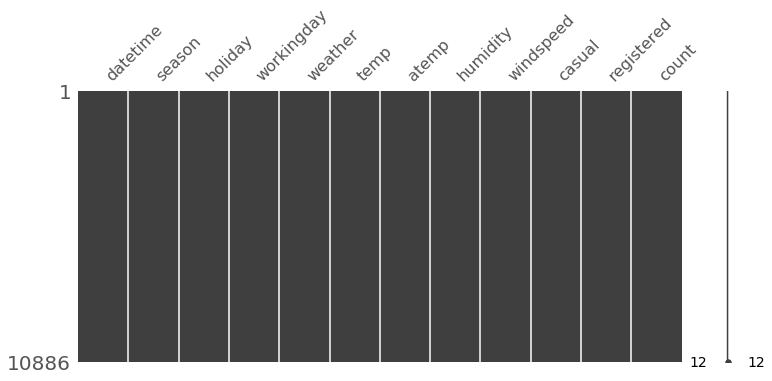

In [4]:
print(train.isnull().sum())

# visualization null data 
import missingno as msno
msno.matrix(train, figsize=(12, 5))

In [5]:
# parsing datetime
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] =train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second
train.shape # col_num : 12 > 18

(10886, 18)

[Text(0.5,0,'hour'), Text(0.5,1,'borrowed by year')]

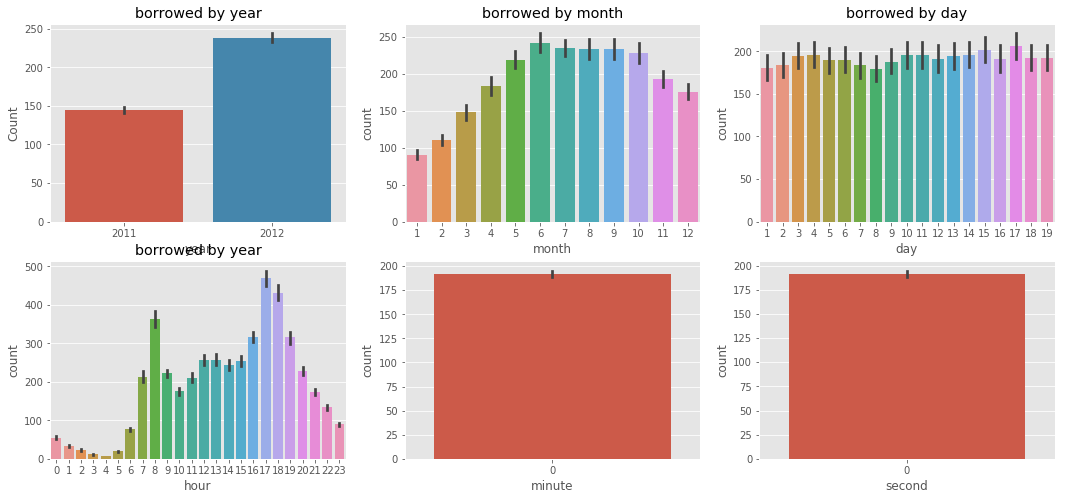

In [6]:
# Amount borrowed by time
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18, 8)

sns.barplot(data=train, x="year", y="count", ax=ax1)
sns.barplot(data=train, x="month", y="count", ax=ax2)
sns.barplot(data=train, x="day", y="count", ax=ax3)
sns.barplot(data=train, x="hour", y="count", ax=ax4)
sns.barplot(data=train, x="minute", y="count", ax=ax5)
sns.barplot(data=train, x="second", y="count", ax=ax6)

ax1.set(ylabel="Count", title="borrowed by year")
ax2.set(xlabel="month", title="borrowed by month")
ax3.set(xlabel="day", title="borrowed by day")
ax4.set(xlabel="hour", title="borrowed by year")

* 2011년 보다 2012년 대여량이 더 많다.
* 날씨가 따뜻한 계절에 대여량이 많다.
* 일별 대여량은 19일까지이므로, feature로 사용하기에는 부적합
* 출퇴근 시간에 대여량이 높다
* 분, 초는 쓸 수 없다. 

[Text(0,0.5,'Count'),
 Text(0.5,0,'Working day'),
 Text(0.5,1,'borrowed by working day')]

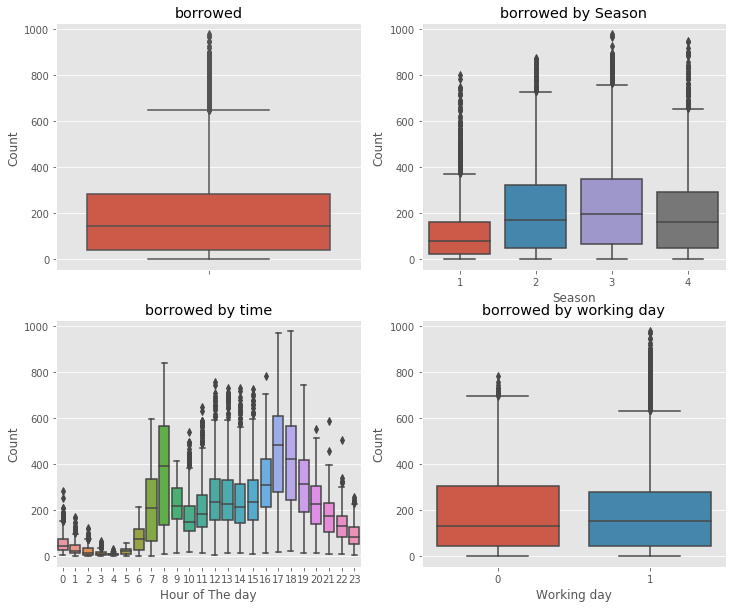

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=train, y="count", orient="v", ax=axes[0][0])
sns.boxplot(data=train, y="count", x="season", orient="v",ax=axes[0][1])
sns.boxplot(data=train, y="count", x="hour", orient="v",ax=axes[1][0])
sns.boxplot(data=train, y="count", x="workingday", orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count', title="borrowed")
axes[0][1].set(xlabel='Season', ylabel='Count', title="borrowed by Season")
axes[1][0].set(xlabel='Hour of The day',ylabel='Count', title="borrowed by time")
axes[1][1].set(xlabel='Working day',ylabel='Count', title="borrowed by working day")

`orient`:  verical(수직) or horizontal(수평)
* 계절별로 보았을 때 여름과 가을이 대여량이 많다. 
* 근무일 여부에 따라서 봤을때는 큰 차이는 없지만, 근무일이 아닐 때 대여량이 많다.

In [8]:
# day of week
train['dayofweek'] = train['datetime'].dt.dayofweek
print(train.shape)
train['dayofweek'].value_counts()

(10886, 19)


5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

The day of the week with Monday=0, Sunday=6

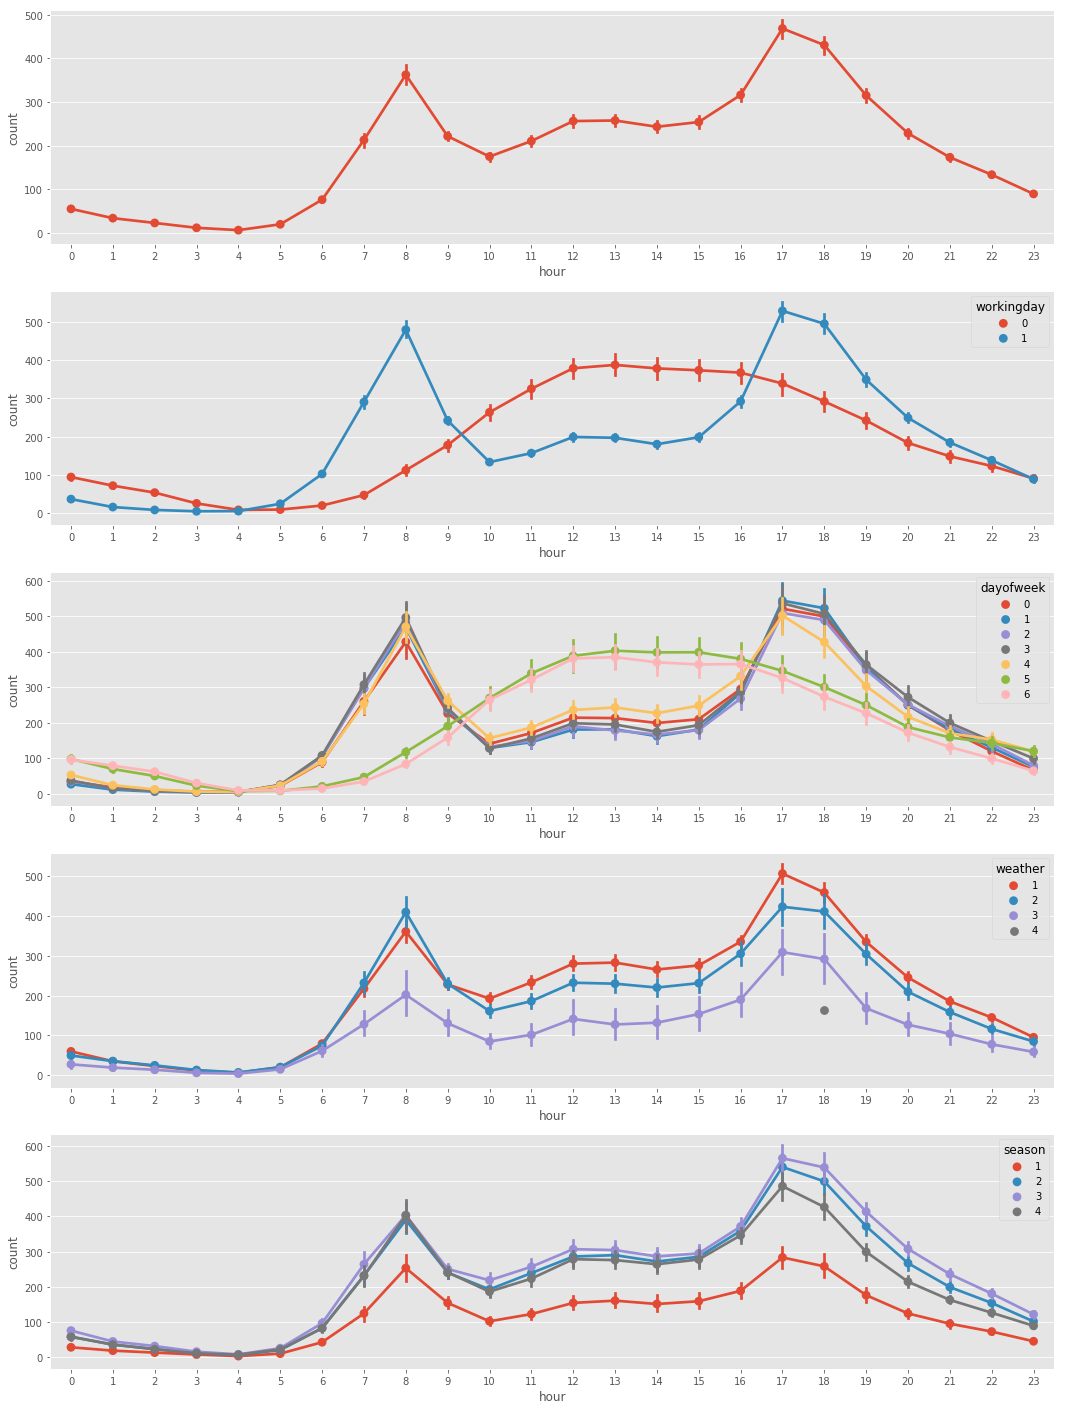

In [9]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5)
fig.set_size_inches(18, 25)

sns.pointplot(data=train, x="hour", y="count", ax=ax1)
sns.pointplot(data=train, x="hour", y="count", hue="workingday", ax=ax2)
sns.pointplot(data=train, x="hour", y="count", hue="dayofweek", ax=ax3)
sns.pointplot(data=train, x="hour", y="count", hue="weather", ax=ax4)
sns.pointplot(data=train, x="hour", y="count", hue="season", ax=ax5)

* 시간별로 count를 살핀다.
* 다양한 그룹을 이용해 시간별에 따른 대여량을 살핀다.
    * 그룹1: workingday 
        * 값이 1인 workingday가 더욱 시간별 전체 대여량 그래프와 비슷한 성향을 띈다.
    * 그룹2: dayofweek
        * 0인 월부터 금까지가 시간별 전체 대여량 그래프와 비슷한 성향
    * 그룹3: weather
        * Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog가 아닌 경우는 시간별에 따라 대여량은 전체와 비슷한 모양을 갖는다.
        * 비가 올 때는 18시에 기록이 있다.
        * 약간 날씨가 꾸물 거릴 때, 아침 8시 대여량이 화창한 날보다 높다(?)
    * 그룹4: season
         * 봄, 여름, 가을은 대여량의 다소 차이는 있지만 시간별에 따라서는 비슷한 성향을 띈다.

                temp     atemp    casual  registered  humidity  windspeed  \
temp        1.000000  0.984948  0.467097    0.318571 -0.064949  -0.017852   
atemp       0.984948  1.000000  0.462067    0.314635 -0.043536  -0.057473   
casual      0.467097  0.462067  1.000000    0.497250 -0.348187   0.092276   
registered  0.318571  0.314635  0.497250    1.000000 -0.265458   0.091052   
humidity   -0.064949 -0.043536 -0.348187   -0.265458  1.000000  -0.318607   
windspeed  -0.017852 -0.057473  0.092276    0.091052 -0.318607   1.000000   
count       0.394454  0.389784  0.690414    0.970948 -0.317371   0.101369   

               count  
temp        0.394454  
atemp       0.389784  
casual      0.690414  
registered  0.970948  
humidity   -0.317371  
windspeed   0.101369  
count       1.000000  


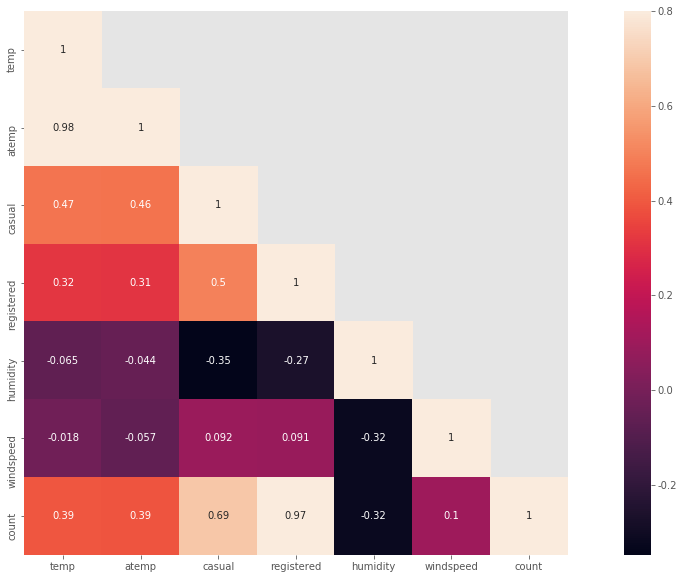

In [10]:
corrMatt = train[["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]]
corrMatt = corrMatt.corr()
print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=True, annot=True)

In [11]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek'],
      dtype='object')

* 시간과 다른 값들의 연관관계를 살펴본다. 
* count와 가장 관련이 높은 변수
    * resistered이다 (등록된 사용자)
        * resistered는 test 데이터에는 값이 없어 feature로는 부적함.
    * casual은 등록되지 않은 사용자로 연관도가 resistered에 뒤이어 높다.
* count와 가장 관련이 낮은 변수
    * 습도와 풍속은 대체적으로 다른 변수들과 상관도가 낮다.
* 온도, 습도, 풍속은 거의 연관관계가 없다(?)
* atemp와 temp는 0.98로 상관관계가 높지만 온도와 체감온도로 피처로 사용하기에 적합하지 않을 수 있다.
    * 거의 같은 데이터로 보여지기 때문

In [12]:
train[['datetime','temp', 'count']].head()

,datetime,temp,count
0,2011-01-01 00:00:00,9.84,16
1,2011-01-01 01:00:00,9.02,40
2,2011-01-01 02:00:00,9.02,32
3,2011-01-01 03:00:00,9.84,13
4,2011-01-01 04:00:00,9.84,1


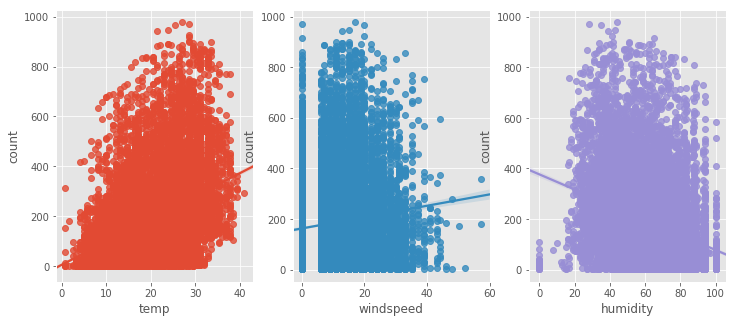

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="temp", y="count", data=train, ax=ax1)
sns.regplot(x="windspeed", y="count", data=train, ax=ax2)
sns.regplot(x="humidity", y="count", data=train, ax=ax3)

* 상관도가 낮았던, 온도, 풍속, 습도 변수로 산점도를 살펴본다.
* 풍속은 0에 데이터가 몰려있다. 
    * 0에 몰려있는 데이터는 feature engineering에서 조정해주는 것이 좋다. 

In [14]:
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)

train["year_month"] = train["datetime"].apply(concatenate_year_month)
print(train.shape)

(10886, 20)


In [15]:
train["year_month"].head()

0    2011-1
1    2011-1
2    2011-1
3    2011-1
4    2011-1
Name: year_month, dtype: object

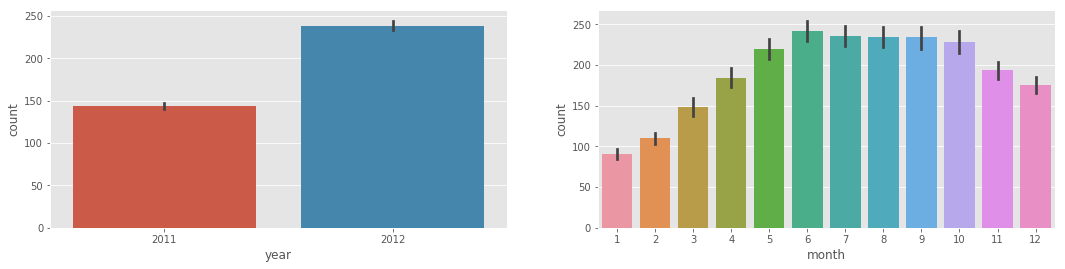

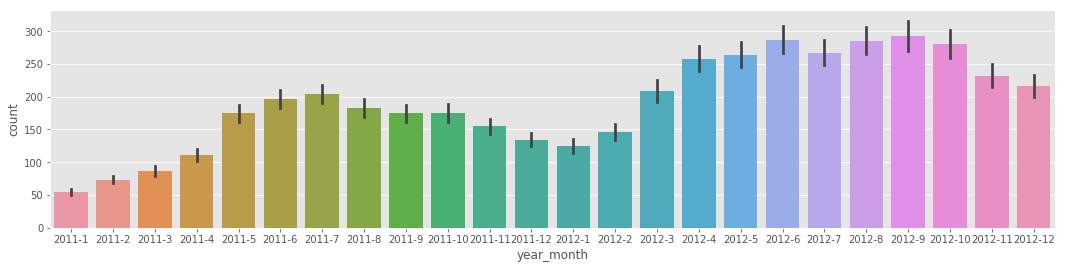

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18, 4)

sns.barplot(data=train, x="year", y="count", ax=ax1)
sns.barplot(data=train, x="month", y="count", ax=ax2)

fig, ax3 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18, 4)

sns.barplot(data=train, x="year_month", y="count", ax=ax3)

* 계속해서 증가하는 추세다

In [18]:
np.abs(train["count"] - train["count"].mean())

0        175.574132
1        151.574132
2        159.574132
3        178.574132
4        190.574132
5        190.574132
6        189.574132
7        188.574132
8        183.574132
9        177.574132
10       155.574132
11       135.574132
12       107.574132
13        97.574132
14        85.574132
15        81.574132
16        98.574132
17       124.574132
18       156.574132
19       154.574132
20       155.574132
21       157.574132
22       163.574132
23       152.574132
24       174.574132
25       174.574132
26       182.574132
27       185.574132
28       188.574132
29       189.574132
            ...    
10856    333.425868
10857    161.425868
10858     76.425868
10859     23.574132
10860     59.574132
10861    110.574132
10862    150.574132
10863    176.574132
10864    188.574132
10865    186.574132
10866    184.574132
10867    160.574132
10868     79.574132
10869    171.425868
10870    486.425868
10871    125.425868
10872     27.574132
10873      8.425868
10874     44.425868


In [22]:
# remove outlier data
# Return sample standard deviation over requested axis.

# 표준편차의 3배까지는 용납
trainWithoutOutliers = train[np.abs(train["count"] - train["count"].mean()) <= (3*train["count"].std())]
# http://blog.naver.com/PostView.nhn?blogId=bluefish850&logNo=220696377742
print(train.shape)
print(trainWithoutOutliers.shape)

(10886, 20)
(10739, 20)


In [23]:
print(train.shape[0]-trainWithoutOutliers.shape[0])

147


C:\Users\hyooo\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\hyooo\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909612))

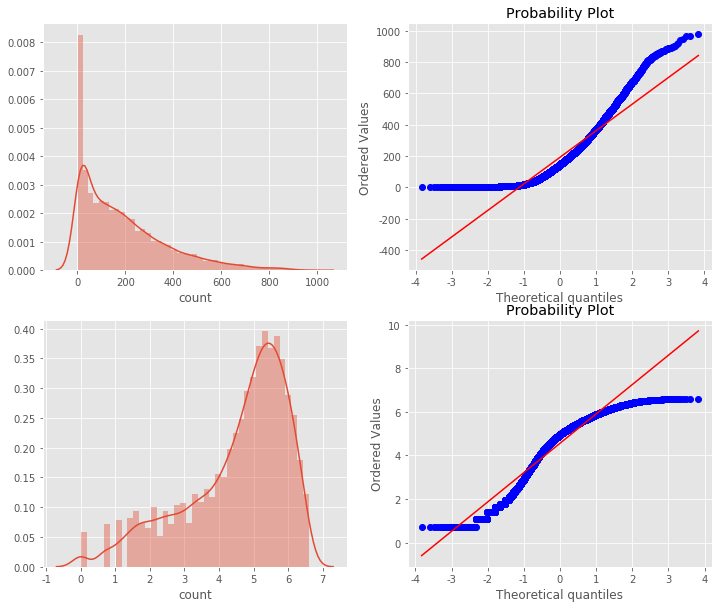

In [34]:
# Count값의 데이터 분포를 파악
figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12, 10)


# The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
sns.distplot(train["count"], ax=axes[0][0])
stats.probplot(train["count"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(trainWithoutOutliers["count"]), ax=axes[1][0])
stats.probplot(np.log1p(trainWithoutOutliers["count"]), dist="norm", fit=True, plot=axes[1][1])

* 0에 몰려있는 데이터를 제거하고 보면 자세히 확대해서 볼 수 있다. 
* 기계학습에서는 종속변수가 정규분포를 갖는 편이 좋다. 

# Feature Engineering

## Scikit-learn

#### Supervised Machine Learning

**RMSLE**

**과대평가 된 항목보다는 과소평가 된 항목에 패널티를 준다**.
오차를 제곱해서 평군한 값의 제곱근으로 값이 작을 수록 정밀도가 높다. 
0에 가까운 값이 나올 수록 정밀도가 높은 값이다. 

EDA & Ensembel Model(Top 10 Percentile)


**교차검증**

**Cross Validation**
Fold를 낸 것 중에 하나를 Test로 하고 나머지를 Train Set이 된다. k번 정확도를 측정하고 그것을 평균낸다

In [36]:
# regression
# https://github.com/amueller/odscon-2015
# 1. 분류기를 가져온다.


# 2. 학습을 시킨다.


# 3. 예측을 한다



# 4. 점수를 낸다.

# Feature Engineering

In [40]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline
# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv("../input/train.csv",
                   parse_dates=["datetime"])
train.shape 
test = pd.read_csv("../input/test.csv",
                   parse_dates=["datetime"])
test.shape

(6493, 9)

In [42]:
# Feature Engineering

# parsing datetime
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] =train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second
train['dayofweek'] = train['datetime'].dt.second
train.shape # col_num : 12 > 18

(10886, 19)

In [43]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

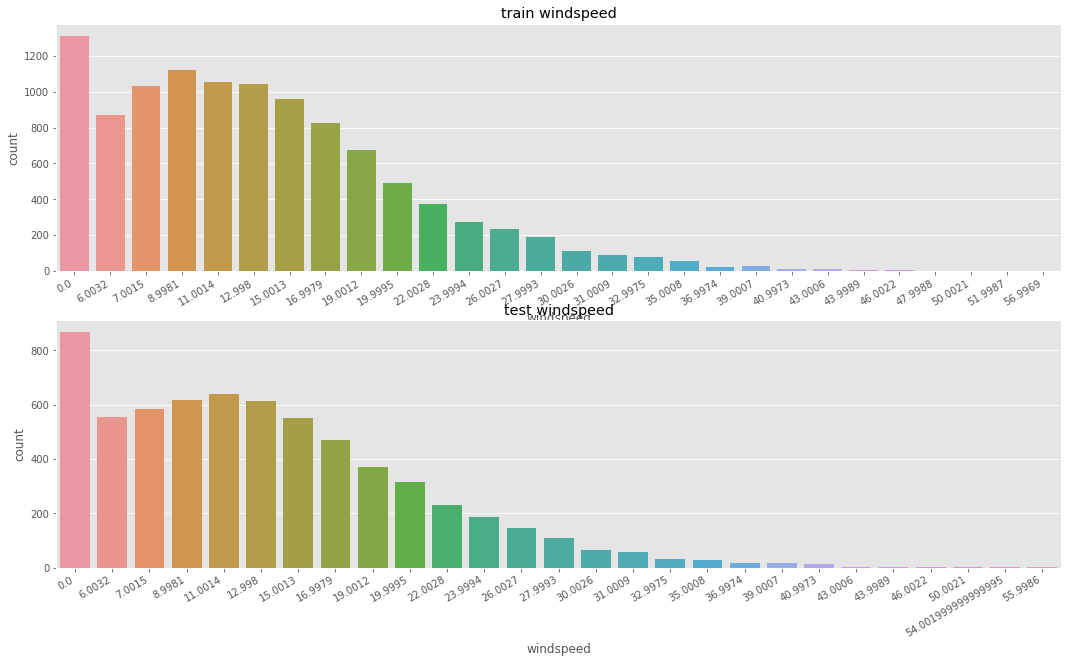

In [46]:
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count', title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count', title="test windspeed")
sns.countplot(data=test, x="windspeed", ax=axes[1])

* 0에 굉장히 많은 값들이 몰려있다. 측저이 되지 않은 값들을 0으로 넣었다. 0의 값들을 보정!

In [ ]:
# mean값으로 대체해도 되지만, 의미있어 보이지 않으므로 다른 방법을 취해준다. 
# train.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()
# test.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()

In [47]:
# 풍속이 0인것과 0이 아닌것으로 나눈다.
trainWind0 = train.loc[train['windspeed']==0]
trainWindNot0= train.loc[train['windspeed']!=0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 19)
(9573, 19)


In [51]:
trainWindNot0["windspeed"].dtype

dtype('float64')

In [69]:
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    # 풍속이 0인 것과 0이 아닌것을 나눠준다.
    dataWind0 = data.loc[data['windspeed']==0]
    dataWindNot0 = data.loc[data['windspeed']!=0]
    
    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", 'month', "temp", "year", "atemp"]
    
    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")
    #????
    
    rfModel_wind = RandomForestClassifier()
    
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"]) # X, Y
    
    wind0Values  = rfModel_wind.predict(X=dataWind0[wCol])
    
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0
    
    predictWind0["windspeed"] = wind0Values 
    
    data=predictWindNot0.append(predictWind0)
    
    data["windspeed"] = data["windspeed"].astype("float")
    
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

## >>>>>>>>>>> show <<<<<<<<<<<<<##

In [53]:
temp_df = train[:10000].copy()

In [54]:
dataWind0 = temp_df.loc[temp_df['windspeed']==0]
dataWindNot0 = temp_df.loc[temp_df['windspeed']!=0]

wCol = ["season", "weather", "humidity", 'month', "temp", "year", "atemp"]

In [56]:
dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")
clf = RandomForestClassifier()
clf.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

wind0Values = clf.predict(X = dataWind0[wCol])

predictWind0 = dataWind0
predictWindNot0 = dataWindNot0

predictWind0["windspeed"] = wind0Values

In [57]:
wind0Values

array(['19.0012', '19.0012', '19.0012', ..., '12.998', '11.0014',
       '11.0014'], dtype=object)

In [58]:
temp_df = predictWindNot0.append(predictWind0)
temp_df["windspeed"] = temp_df["windspeed"].astype('float')
temp_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,2011,1,1,5,0,0,0
10,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,12,24,36,2011,1,1,10,0,0,0
11,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,26,30,56,2011,1,1,11,0,0,0
12,2011-01-01 12:00:00,1,0,0,1,17.22,21.210,77,19.0012,29,55,84,2011,1,1,12,0,0,0
13,2011-01-01 13:00:00,1,0,0,2,18.86,22.725,72,19.9995,47,47,94,2011,1,1,13,0,0,0


In [59]:
temp_df.reset_index(inplace=True)

In [60]:
temp_df.head(3)

,index,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,2011,1,1,5,0,0,0
1,10,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,12,24,36,2011,1,1,10,0,0,0
2,11,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,26,30,56,2011,1,1,11,0,0,0


In [61]:
temp_df.drop('index', inplace=True, axis=1)

In [62]:
temp_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,2011,1,1,5,0,0,0
1,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,12,24,36,2011,1,1,10,0,0,0
2,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,26,30,56,2011,1,1,11,0,0,0


In [63]:
del temp_df

## >>>>>>>>>>> end <<<<<<<<<<<<<##

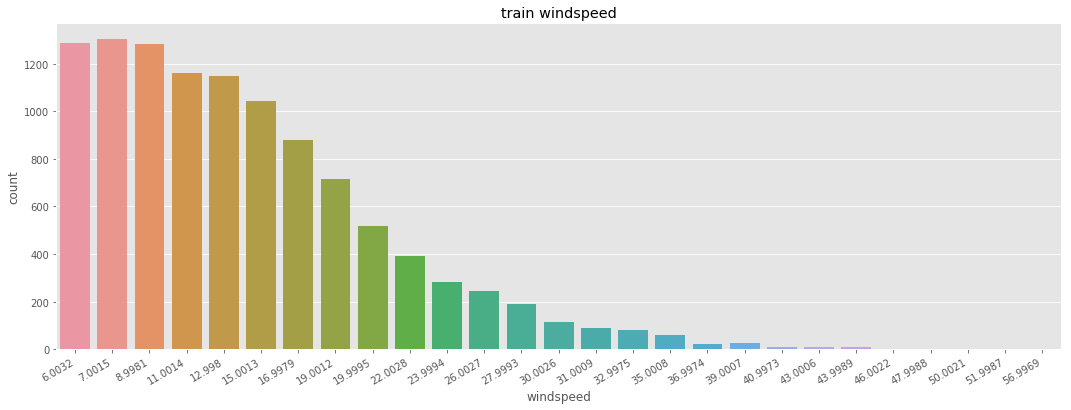

In [70]:
# 0값을 조정
train = predict_windspeed(train)

fig, ax1 = plt.subplots()
fig.set_size_inches(18, 6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=ax1)

## Feature Selection
* 신호와 잡음을 구분
* 피처가 많다고 해서 무조건 좋은 성능을 내는 것은 아니다.
* 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다.


In [71]:
# 연속형 feature
# 범주형 feature

categorical_feature_names = ["season", "holiday", "workingday", "weather",
                            "dayofweek", "month", "year", "hour"]

# one hot encoding

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [73]:
train[categorical_feature_names].head()

,season,holiday,workingday,weather,dayofweek,month,year,hour
0,1,0,0,2,0,1,2011,5
1,1,0,0,1,0,1,2011,10
2,1,0,0,1,0,1,2011,11
3,1,0,0,1,0,1,2011,12
4,1,0,0,2,0,1,2011,13


In [74]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek", "holiday", "workingday"]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [75]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,0,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,0,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,0,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,0,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,0,0,0


In [77]:
X_test = test[feature_names]
print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [78]:
label_name = "count"
y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

## Score
### RMSLE

In [82]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

from sklearn.ensemble import RandomForestRegressor
max_depth_list = []
model = RandomForestRegressor(n_estimators=100,
                             n_jobs=-1,
                             random_state=0)
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [84]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)

    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)

    # 평균을 낸다.
    mean_difference = difference.mean()

    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)

    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [85]:
rmsle

<function __main__.rmsle(predicted_values, actual_values)>

In [86]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()

Wall time: 29.1 s


In [87]:
print("Score={0:.5f}".format(score))

Score=0.35206


## Train

In [88]:
# 학습시킴, 피팅(옷을 맞출 때 사용하는 피팅을 생각함) - 피처와 레이블을 넣어주면 알아서 학습을 함
model.fit(X_train, y_train)

# 예측
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([  9.93,   4.83,   4.42,   3.53,   2.94,   6.56,  39.21, 104.34,
       232.62, 129.29])

[Text(0.5,1,'test')]

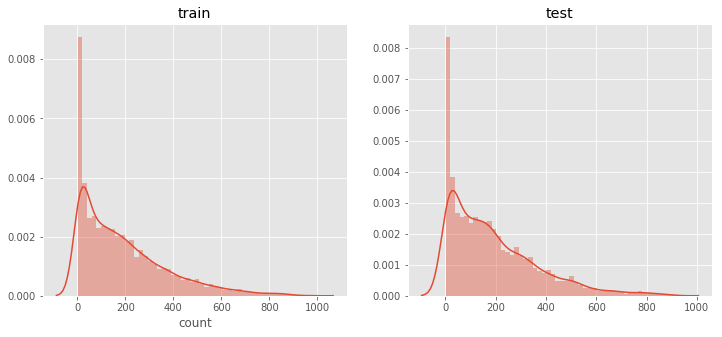

In [89]:
# 예측한 데이터를 시각화 해본다. 
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

## Submit

In [90]:
submission = pd.read_csv("../input/sampleSubmission.csv")
submission

submission["count"] = predictions
print(submission.shape)

submission.to_csv("../output/Score_{0:.5f}_submission.csv".format(score), index=False)

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0
5,2011-01-20 05:00:00,0
6,2011-01-20 06:00:00,0
7,2011-01-20 07:00:00,0
8,2011-01-20 08:00:00,0
9,2011-01-20 09:00:00,0
